# Dropout, функции активации и PyTorch-сеть для предсказания пороков сердца

---

## Что вы изучите сегодня
### 1) Dropout (регуляризация)
- зачем нужен Dropout
- почему он работает только в `model.train()`
- как выбирать `p` (например 0.1–0.5)

### 2) Нейросеть на PyTorch (минимальный пайплайн)
- DataFrame → numpy → torch.Tensor
- Dataset + DataLoader
- модель → loss → optimizer → обучение
- оценка качества (accuracy + confusion matrix + F1)

### 3) Функции активации и проблемы градиентов
- для выхода: **Sigmoid**, **Softmax**
- для скрытых: **Sigmoid**, **tanh**, **ReLU**, **LeakyReLU**, **Swish**
- “вымывание градиента” (vanishing)
- “взрыв градиента” (exploding)
- простые решения

### 4) Кейс: предсказание “пороков сердца” (binary classification)
- сгенерируем маленький учебный датасет (похож на медицинские признаки)
- построим сеть и сравним **без Dropout vs с Dropout**
- сохраним модель и загрузим обратно

In [2]:
# Если библиотек нет (обычно в Colab всё есть):
# !pip install torch scikit-learn pandas matplotlib --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
print("torch:", torch.__version__)

device: cpu
torch: 2.9.0+cpu


# 1) Dropout регуляризация — что это?

## Идея
Dropout — это техника, которая **случайно “выключает” часть нейронов** во время обучения.

Если `p=0.3`, это означает:
- примерно **30% активаций зануляются**
- модель не может “надеяться” на один конкретный нейрон
- она учится распределять знания по сети

## Почему это снижает переобучение?
Переобучение = модель “запомнила train”, но плохо работает на новых данных.

Dropout заставляет сеть быть “устойчивой”:
- как будто мы обучаем много “слегка отличающихся сетей”
- и потом усредняем их поведение

## Очень важное правило
- `model.train()` → Dropout **включён**
- `model.eval()` → Dropout **выключен** (всё работает стабильно)

## Типичные значения
- 0.1–0.2: лёгкая регуляризация
- 0.3–0.5: сильнее, если модель переобучается


In [22]:
# Мини-демо: Dropout в train и eval режимах
drop = nn.Dropout(p=0.5)

x = torch.ones(10)  # десять единиц
print("input:", x)

drop.train()
print("train mode dropout:", drop(x))

drop.eval()
print("eval mode dropout :", drop(x))

input: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
train mode dropout: tensor([2., 2., 2., 2., 2., 0., 2., 0., 0., 2.])
eval mode dropout : tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


# 2) Функции активации — зачем они нужны?

Без активаций нейросеть была бы просто “линейной”:
- Linear → Linear → Linear = всё равно Linear  
то есть сеть не могла бы учить сложные зависимости.

**Функция активации делает модель нелинейной.**

---

## Активации для выходного слоя
### Sigmoid (binary classification)
- превращает число (logit) в вероятность 0..1

### Softmax (multi-class classification)
- превращает logits в вероятности, сумма = 1

---

## Активации для скрытых слоёв
- Sigmoid — часто даёт вымывание градиента (плохая для глубоких сетей)
- tanh — лучше sigmoid, но тоже может “насыщаться”
- ReLU — очень популярная, быстро учится
- LeakyReLU — версия ReLU, чтобы избежать “мертвых нейронов”
- Swish — плавная современная (часто хорошо работает)


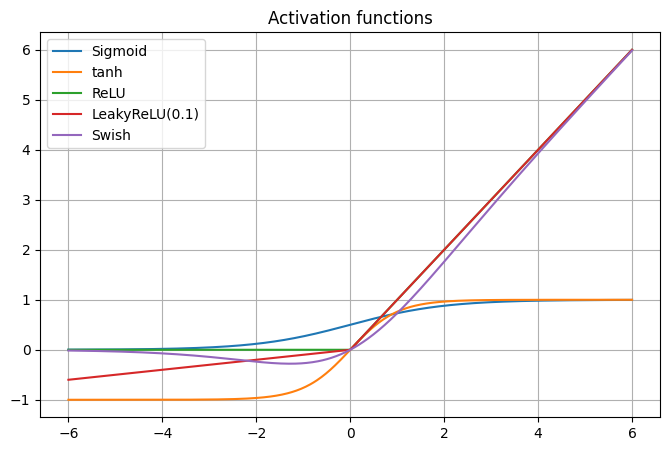

In [23]:
# Графики активаций (очень наглядно)
x = np.linspace(-6, 6, 500)

sigmoid = 1 / (1 + np.exp(-x))
tanh = np.tanh(x)
relu = np.maximum(0, x)
leaky_relu = np.where(x > 0, x, 0.1 * x)
swish = x * (1 / (1 + np.exp(-x)))  # x * sigmoid(x)

plt.figure(figsize=(8,5))
plt.plot(x, sigmoid, label="Sigmoid")
plt.plot(x, tanh, label="tanh")
plt.plot(x, relu, label="ReLU")
plt.plot(x, leaky_relu, label="LeakyReLU(0.1)")
plt.plot(x, swish, label="Swish")
plt.title("Activation functions")
plt.grid(True)
plt.legend()
plt.show()

# 3) Вымывание и взрыв градиента

## Vanishing gradients
Градиенты становятся **очень маленькими** → сеть почти не учится.

Часто бывает из-за:
- sigmoid/tanh в глубоких сетях (насыщение)
- много слоёв подряд

Решения (база):
- ReLU/LeakyReLU в скрытых слоях
- нормализация входов
- BatchNorm (позже)
- хорошая инициализация

## Exploding gradients
Градиенты становятся **слишком большими** → loss скачет → NaN.

Решения (база):
- уменьшить learning rate
- gradient clipping


In [6]:
# Gradient clipping (памятка)
# torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

print("Gradient clipping — это ограничение нормы градиента, чтобы обучение не ломалось.")

Gradient clipping — это ограничение нормы градиента, чтобы обучение не ломалось.


# 4) Учебный датасет “пороки сердца”

Чтобы не возиться с файлами, генерируем небольшой датасет, похожий на медицинские признаки.

Цель `target`:
- 1 → риск/наличие проблемы
- 0 → нет

> Учебный пример, не медицинский.


In [24]:
# Генерация учебного датасета
N = 1400

age = np.random.randint(29, 78, size=N)
sex = np.random.randint(0, 2, size=N)  # 0/1
chol = np.random.normal(220, 35, size=N).clip(120, 380)
bp = np.random.normal(130, 18, size=N).clip(90, 200)
max_hr = np.random.normal(150, 22, size=N).clip(80, 210)
glucose = np.random.normal(100, 20, size=N).clip(60, 220)
chest_pain = np.random.randint(0, 4, size=N)  # 0..3
smoker = (np.random.rand(N) < 0.28).astype(int)
bmi = np.random.normal(26.5, 4.2, size=N).clip(16, 45)
stress = np.random.randint(0, 11, size=N)  # 0..10

logit = (
    0.04*(age-50) +
    0.015*(chol-200) +
    0.02*(bp-120) -
    0.015*(max_hr-150) +
    0.02*(glucose-95) +
    0.35*smoker +
    0.08*(bmi-25) +
    0.10*(stress-5) +
    0.18*(chest_pain) +
    0.10*sex
)
prob = 1 / (1 + np.exp(-logit))
target = (np.random.rand(N) < prob).astype(int)

df = pd.DataFrame({
    "age": age,
    "sex": sex,
    "cholesterol": chol,
    "systolic_bp": bp,
    "max_hr": max_hr,
    "glucose": glucose,
    "chest_pain": chest_pain,
    "smoker": smoker,
    "bmi": bmi,
    "stress": stress,
    "target": target
})
df.head()


,age,sex,cholesterol,systolic_bp,max_hr,glucose,chest_pain,smoker,bmi,stress,target
0,34,1,155.194461,133.097061,180.037232,88.504135,0,0,36.354886,2,0
1,43,1,248.649205,119.409492,145.527439,125.592282,2,0,29.256818,4,0
2,64,0,200.860654,130.230657,176.127020,128.985849,2,0,32.769894,8,1
3,61,1,185.424967,108.967164,146.707019,97.736587,2,1,29.527054,6,1
4,52,0,264.479597,115.768768,128.711559,90.986636,3,1,24.256100,1,1


In [25]:
# Быстрый взгляд на статистику
df.describe().T


,count,mean,std,min,25%,50%,75%,max
age,1400.0,52.575714,14.293862,29.000000,40.000000,52.000000,64.000000,77.000000
sex,1400.0,0.514286,0.499974,0.000000,0.000000,1.000000,1.000000,1.000000
cholesterol,1400.0,221.378649,35.647273,120.000000,196.762183,221.377517,245.692375,340.011867
systolic_bp,1400.0,130.242367,18.028634,90.000000,118.066813,130.304243,142.310597,200.000000
max_hr,1400.0,150.799269,21.542615,85.457046,136.129476,150.781534,165.552154,210.000000
glucose,1400.0,100.530090,19.730601,60.000000,86.837800,100.260430,114.414967,161.933910
chest_pain,1400.0,1.505000,1.102329,0.000000,1.000000,2.000000,2.000000,3.000000
smoker,1400.0,0.283571,0.450892,0.000000,0.000000,0.000000,1.000000,1.000000
bmi,1400.0,26.519884,4.171800,16.000000,23.628129,26.494295,29.342861,41.667670
stress,1400.0,5.100714,3.110406,0.000000,2.000000,5.000000,8.000000,10.000000


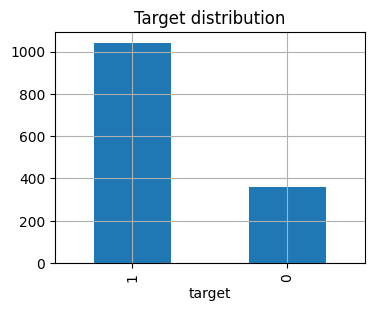

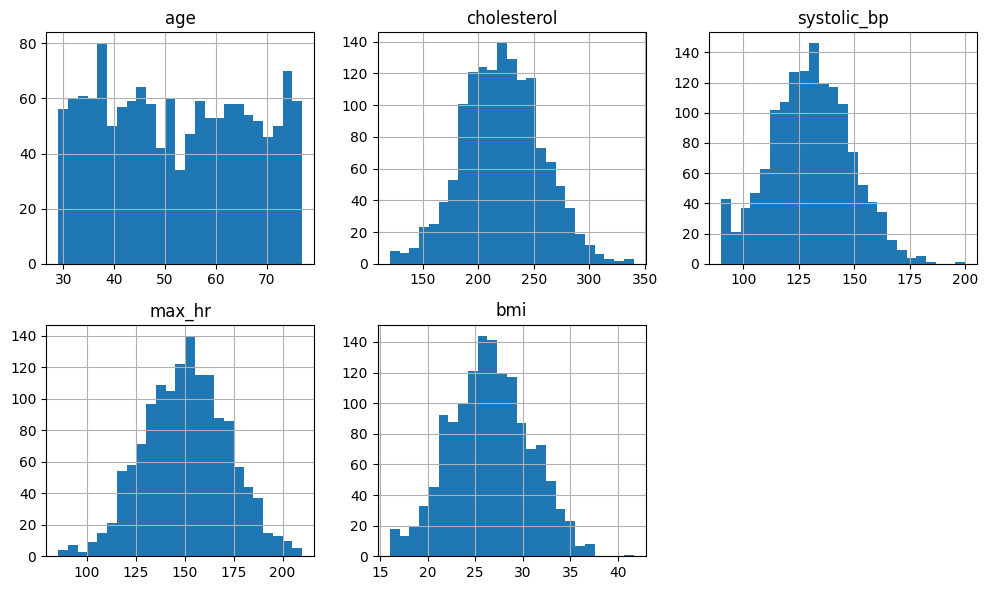

In [26]:
# Мини-EDA
plt.figure(figsize=(4,3))
df["target"].value_counts().plot(kind="bar")
plt.title("Target distribution")
plt.grid(True)
plt.show()

cols = ["age", "cholesterol", "systolic_bp", "max_hr", "bmi"]
plt.figure(figsize=(10,6))
for i, c in enumerate(cols, 1):
    plt.subplot(2, 3, i)
    plt.hist(df[c], bins=25)
    plt.title(c)
    plt.grid(True)
plt.tight_layout()
plt.show()


# 5) Подготовка данных (preprocessing)

1) X/y  
2) train/test split  
3) StandardScaler (fit на train)  
4) torch.Tensor + reshape y -> (n,1)  
5) DataLoader  


In [27]:
TARGET_COL = "target"
X = df.drop(columns=[TARGET_COL]).copy()
y = df[TARGET_COL].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)

X_test_t  = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t  = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False)

xb, yb = next(iter(train_loader))
print("batch X:", xb.shape, xb.dtype)
print("batch y:", yb.shape, yb.dtype)


batch X: torch.Size([64, 10]) torch.float32
batch y: torch.Size([64, 1]) torch.float32


# 6) Нейросеть для бинарной классификации + Dropout

Выход: **1 logit**  
Loss: **BCEWithLogitsLoss** (сигмоида внутри)

Сделаем:
- без Dropout
- с Dropout (0.3)


In [29]:
class HeartNet(nn.Module):
    def __init__(self, n_in, hidden=32, dropout=0.0):
        super().__init__()
        self.fc1 = nn.Linear(n_in, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, 1)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        logits = self.fc3(x)
        return logits

n_features = X_train_t.shape[1]
model_no_drop = HeartNet(n_in=n_features, hidden=32, dropout=0.0).to(device)
model_drop    = HeartNet(n_in=n_features, hidden=32, dropout=0.3).to(device)

print("params:", sum(p.numel() for p in model_drop.parameters()))

params: 1441


# 7) Train/Eval

Предсказание класса:
- logits -> sigmoid -> probability
- probability >= threshold -> 1 иначе 0


In [30]:
criterion = nn.BCEWithLogitsLoss()

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for Xb, yb in loader:
        Xb = Xb.to(device)
        yb = yb.to(device)

        logits = model(Xb)
        loss = criterion(logits, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * Xb.size(0)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, device, threshold=0.5):
    model.eval()
    probs_all, y_all = [], []
    for Xb, yb in loader:
        Xb = Xb.to(device)
        logits = model(Xb)
        probs = torch.sigmoid(logits).cpu().numpy().reshape(-1)
        probs_all.append(probs)
        y_all.append(yb.numpy().reshape(-1))

    probs = np.concatenate(probs_all)
    y_true = np.concatenate(y_all).astype(int)
    y_pred = (probs >= threshold).astype(int)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    return acc, f1, cm, probs, y_true, y_pred

In [31]:
def fit_model(model, train_loader, test_loader, epochs=15, lr=1e-3, threshold=0.5):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = []

    for epoch in range(1, epochs+1):
        loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        acc, f1, cm, *_ = evaluate(model, test_loader, device, threshold=threshold)
        history.append((epoch, loss, acc, f1))
        if epoch % 5 == 0:
            print(f"epoch={epoch:02d} loss={loss:.4f} acc={acc:.4f} f1={f1:.4f}")

    return pd.DataFrame(history, columns=["epoch","loss","acc","f1"])

# 8) Baseline: без Dropout

In [32]:
hist_no = fit_model(model_no_drop, train_loader, test_loader, epochs=15, lr=1e-3)
hist_no.tail()

epoch=05 loss=0.5085 acc=0.7429 f1=0.8525
epoch=10 loss=0.4564 acc=0.7500 f1=0.8478
epoch=15 loss=0.4445 acc=0.7536 f1=0.8470


,epoch,loss,acc,f1
10,11,0.453598,0.753571,0.848352
11,12,0.450632,0.753571,0.848352
12,13,0.448539,0.760714,0.851441
13,14,0.446526,0.757143,0.849558
14,15,0.444497,0.753571,0.847007


In [33]:
acc, f1, cm, probs, y_true, y_pred = evaluate(model_no_drop, test_loader, device, threshold=0.5)
print("No Dropout -> acc:", acc, "f1:", f1)
print("CM:\n", cm)
print("Report:\n", classification_report(y_true, y_pred, digits=3))

No Dropout -> acc: 0.7535714285714286 f1: 0.8470066518847007
CM:
 [[ 20  52]
 [ 17 191]]
Report:
               precision    recall  f1-score   support

           0      0.541     0.278     0.367        72
           1      0.786     0.918     0.847       208

    accuracy                          0.754       280
   macro avg      0.663     0.598     0.607       280
weighted avg      0.723     0.754     0.724       280



# 9) С Dropout и сравнение

In [34]:
hist_drop = fit_model(model_drop, train_loader, test_loader, epochs=15, lr=1e-3)
hist_drop.tail()


epoch=05 loss=0.5199 acc=0.7429 f1=0.8525
epoch=10 loss=0.4941 acc=0.7464 f1=0.8518
epoch=15 loss=0.4754 acc=0.7536 f1=0.8503


,epoch,loss,acc,f1
10,11,0.486340,0.735714,0.843882
11,12,0.477881,0.742857,0.846809
12,13,0.474803,0.746429,0.847966
13,14,0.488220,0.753571,0.850325
14,15,0.475430,0.753571,0.850325


In [35]:
acc2, f12, cm2, *_ = evaluate(model_drop, test_loader, device, threshold=0.5)
print("Dropout -> acc:", acc2, "f1:", f12)
print("CM:\n", cm2)


Dropout -> acc: 0.7535714285714286 f1: 0.8503253796095445
CM:
 [[ 15  57]
 [ 12 196]]


In [36]:
# Порог
for thr in [0.3, 0.5, 0.7]:
    acc_thr, f1_thr, cm_thr, *_ = evaluate(model_drop, test_loader, device, threshold=thr)
    print(f"thr={thr} -> acc={acc_thr:.4f}, f1={f1_thr:.4f}, CM={cm_thr.tolist()}")


thr=0.3 -> acc=0.7429, f1=0.8525, CM=[[0, 72], [0, 208]]
thr=0.5 -> acc=0.7536, f1=0.8503, CM=[[15, 57], [12, 196]]
thr=0.7 -> acc=0.7071, f1=0.7853, CM=[[48, 24], [58, 150]]


# 10) Save/Load модели

In [21]:
MODEL_PATH = "/heartnet_state_dict.pt"
torch.save(model_drop.state_dict(), MODEL_PATH)
print("Saved:", MODEL_PATH)

model_loaded = HeartNet(n_in=n_features, hidden=32, dropout=0.3).to(device)
model_loaded.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model_loaded.eval()

accL, f1L, cmL, *_ = evaluate(model_loaded, test_loader, device, threshold=0.5)
print("Loaded -> acc:", accL, "f1:", f1L)
print("CM:\n", cmL)


Saved: /heartnet_state_dict.pt
Loaded -> acc: 0.7607142857142857 f1: 0.8559139784946237
CM:
 [[ 14  59]
 [  8 199]]


---
# 10 задач на закрепление (дополнить код)
**Формат:** задание → подсказка → код с пропусками `_____`.


## Задание 1

**Задание:** Постройте графики: sigmoid, tanh, relu.

**Подсказка:** np.linspace, np.tanh, np.maximum


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-6, 6, 400)
sigmoid = 1 / (1 + np.exp(-_____))
tanh = np._____(x)
relu = np.maximum(_____, _____)

plt.figure(figsize=(7,4))
plt.plot(_____, _____, label="sigmoid")
plt.plot(_____, _____, label="tanh")
plt.plot(_____, _____, label="relu")
plt.grid(True)
plt.legend()
plt.show()

## Задание 2

**Задание:** Dropout: покажите train vs eval.

**Подсказка:** drop.train(), drop.eval()


In [ ]:
import torch
import torch.nn as nn

drop = nn.Dropout(p=_____)
x = torch._____(10)

drop._____()
print("train:", drop(x))

drop._____()
print("eval :", drop(x))

## Задание 3

**Задание:** train_test_split со stratify.

**Подсказка:** train_test_split(..., stratify=y)


In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["target"])
y = df["target"]

X_train, _____, y_train, _____ = train_test_split(
    X, y, test_size=_____, random_state=_____, stratify=_____
)
print(X_train.shape, X_test.shape)

## Задание 4

**Задание:** StandardScaler: fit на train, transform на test.

**Подсказка:** fit_transform / transform


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = _____()
X_train_scaled = scaler._____(X_train)
X_test_scaled  = scaler._____(X_test)
X_train_scaled.shape, X_test_scaled.shape

## Задание 5

**Задание:** torch.Tensor + reshape y -> (n,1).

**Подсказка:** torch.tensor + reshape(-1,1)


In [ ]:
import torch

X_train_t = torch._____(_____, dtype=torch._____)
y_train_t = torch.tensor(_____.values, dtype=torch.float32).reshape(_____, _____)
print(X_train_t.shape, y_train_t.shape)

## Задание 6

**Задание:** TensorDataset + DataLoader.

**Подсказка:** TensorDataset(X,y) + DataLoader(...)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(_____, _____)
train_loader = DataLoader(_____, batch_size=_____, shuffle=_____)

xb, yb = next(iter(_____))
print(xb.shape, yb.shape)

## Задание 7

**Задание:** Допишите модель с Dropout и ReLU.

**Подсказка:** nn.Dropout, F.relu


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class HeartNetStudent(nn.Module):
    def __init__(self, n_in, hidden=32, dropout=0.3):
        super().__init__()
        self.fc1 = nn.Linear(n_in, _____)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(_____, 1)
        self.drop = nn._____(_____)

    def forward(self, x):
        x = F._____(self.fc1(x))
        x = self.drop(_____)
        x = F._____(self.fc2(x))
        x = self.drop(_____)
        logits = self.fc3(_____)
        return logits

m = HeartNetStudent(n_in=X_train_t.shape[1])
print(m)

## Задание 8

**Задание:** Один шаг обучения (BCEWithLogitsLoss + Adam).

**Подсказка:** zero_grad/backward/step


In [ ]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HeartNetStudent(n_in=X_train_t.shape[1]).to(_____)

criterion = nn._____()
optimizer = torch.optim._____(model.parameters(), lr=_____)

xb, yb = next(iter(train_loader))
xb = xb.to(_____)
yb = yb.to(_____)

logits = model(_____)
loss = criterion(_____, _____)

optimizer._____()
loss._____()
optimizer._____()

print("loss:", loss.item())

## Задание 9

**Задание:** predict: logits -> sigmoid -> threshold -> pred

**Подсказка:** torch.sigmoid


In [ ]:
import torch
import numpy as np

model.eval()
with torch.no_grad():
    logits = model(xb)
    probs = torch._____(logits).cpu().numpy().reshape(-1)
    thr = _____
    y_pred = (probs >= _____).astype(int)

print("probs[:5]:", probs[:5])
print("pred[:5] :", y_pred[:5])

## Задание 10

**Задание:** Сохраните state_dict и загрузите.

**Подсказка:** torch.save + load_state_dict


In [ ]:
import torch

path = "/tmp_heartnet.pt"
torch.save(model._____, path)

model2 = _____(n_in=X_train_t.shape[1]).to(_____)
model2.load_state_dict(torch.load(_____, map_location=_____))
model2.eval()

print("loaded ok")